In [3]:
# 라이브러리 불러오기
import model.download.api as api
import pandas as pd
from sqlalchemy import inspect
from sqlalchemy.sql import text

import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

# 한글 폰트 설정
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [4]:
# DB 엔진 연결하기
eng = api.create_engine('sqlite:///real_estate.db')

### DB
- 테이블 명 : ['apt', 'apt_raw', 'commerical']
- 칼럼 명 :
       - ['거래금액', '거래유형', '건축년도', '년', '도로명', '도로명건물본번호코드', '도로명건물부번호코드',
       '도로명시군구코드', '도로명일련번호코드', '도로명지상지하코드', '도로명코드', '동', '등기일자', '매도자',
       '매수자', 
       * '법정동', '법정동본번코드', '법정동부번코드', '법정동시군구코드', '법정동읍면동코드', '법정동지번코드',
       '아파트', '월', '일', '일련번호', '전용면적', '중개사소재지', '지번', '지역코드', '층', '해제사유발생일',
       '해제여부']

## 중복 데이터 제거

In [99]:
# 거래금액, 건물면적, 거래시점(년,월,일), 지역코드가 일치하면 중복 데이터로 간주
inspector = inspect(eng)
tables = inspector.get_table_names()
if 'apt' not in tables:
    create_table_query = text('''
        CREATE TABLE apt AS
        SELECT *
        FROM apt_raw
        WHERE ROWID IN (
            SELECT MIN(ROWID)
            FROM apt_raw
            GROUP BY 거래금액, 건물면적, 년, 월, 일, 지역코드
        )
    ''')

    with eng.connect() as conn:
        conn.execute(create_table_query)
    print("commercial 테이블이 생성")
else:
    print("commercial 테이블이 이미 존재")


commercial 테이블이 이미 존재


In [41]:
with eng.connect() as conn:
    query = text('SELECT COUNT(*) FROM apt_raw')
    result = conn.execute(query)
    print(result.scalar())

    query = text('SELECT COUNT(*) FROM apt')
    result= conn.execute(query)
    print(result.scalar())

10960451
9965229


# EDA

## 아웃라이어 확인

In [25]:
import seaborn as sns

query = text('SELECT * FROM apt ORDER BY RANDOM() LIMIT 10000')
with eng.connect() as conn:
    df = pd.read_sql(query, conn)

# '거래금액' 칼럼을 숫자 형식으로 변환 (쉼표 제거 후 변환)
df['거래금액'] = df['거래금액'].replace(',', '', regex=True).astype(float)
df['전용면적'] = df['전용면적'].astype(float)

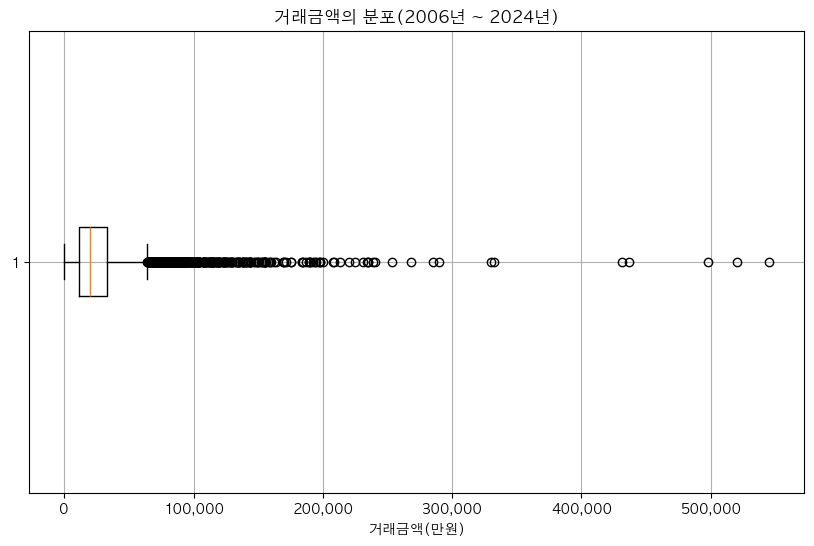

In [27]:
# 상자그림 그리기
plt.figure(figsize=(10, 6))
plt.boxplot(df['거래금액'], vert = False)
plt.xlabel('거래금액(만원)')
plt.title('거래금액의 분포(2006년 ~ 2024년)')
plt.grid(True)
import matplotlib.ticker as ticker
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:,.0f}'))

plt.show()

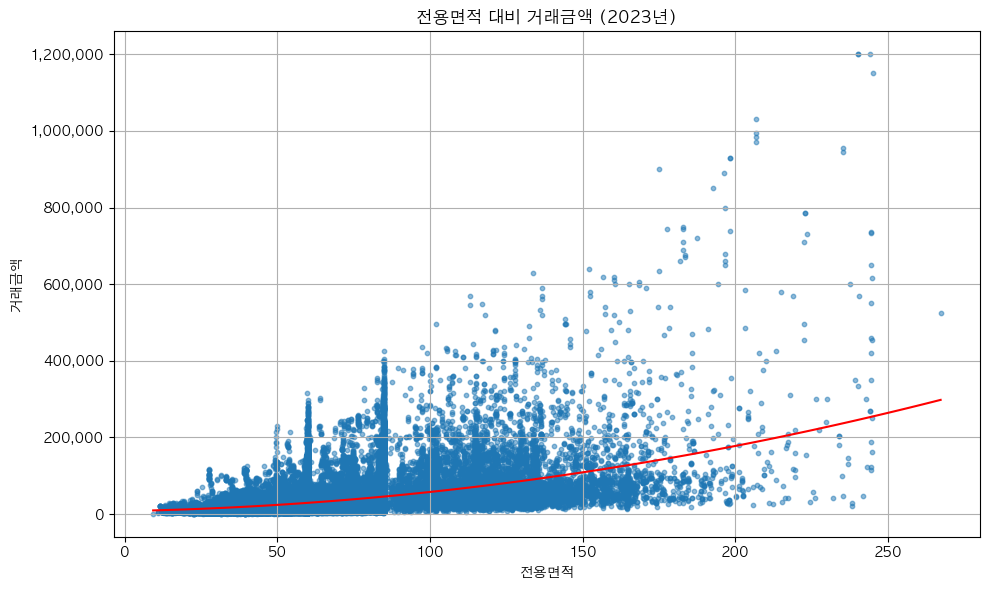

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sqlalchemy import create_engine, text
import matplotlib.ticker as ticker

X = df['전용면적'].values.reshape(-1, 1)
y = df['거래금액'].values

# Polynomial Features 생성 (2차 다항식)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# 선형 회귀 모델 적합
model = LinearRegression()
model.fit(X_poly, y)

# 예측값 계산
X_fit = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_fit = model.predict(poly.transform(X_fit))

# 산점도와 다항 회귀선 그리기
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.5, s=10)
plt.plot(X_fit, y_fit, color='red')
plt.xlabel('전용면적')
plt.ylabel('거래금액')
plt.title('전용면적 대비 거래금액 (2023년)')
plt.grid(True)

# y축 숫자 형식을 변경하여 모든 숫자를 표시
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f'{y:,.0f}'))

plt.tight_layout()
plt.show()

In [6]:
import pandas as pd
from sqlalchemy import create_engine, text

import seaborn as sns

query = text('SELECT * FROM apt ORDER BY RANDOM() LIMIT 100000')
with eng.connect() as conn:
    df = pd.read_sql(query, conn)

# '거래금액' 칼럼을 숫자 형식으로 변환 (쉼표 제거 후 변환)
df['거래금액'] = df['거래금액'].replace(',', '', regex=True).astype(float)
df['전용면적'] = df['전용면적'].astype(float)

# IQR 방법을 사용하여 아웃라이어 제거
Q1 = df['거래금액'].quantile(0.25)
Q3 = df['거래금액'].quantile(0.75)
IQR = Q3 - Q1

# Lower bound and upper bound
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 아웃라이어를 제거한 데이터프레임
df_filtered = df[(df['거래금액'] >= lower_bound) & (df['거래금액'] <= upper_bound)]

#
print(lower_bound)
print(upper_bound)

# 결과 확인
print(f"Original data count: {len(df)}")
print(f"Filtered data count: {len(df_filtered)}")


-19500.0
63700.0
Original data count: 100000
Filtered data count: 93662


In [5]:
import pandas as pd
from sqlalchemy import create_engine, text

import seaborn as sns

query = text('SELECT * FROM apt where "년" = 2024')
with eng.connect() as conn:
    df = pd.read_sql(query, conn)

# '거래금액' 칼럼을 숫자 형식으로 변환 (쉼표 제거 후 변환)
df['거래금액'] = df['거래금액'].replace(',', '', regex=True).astype(float)
df['전용면적'] = df['전용면적'].astype(float)

# IQR 방법을 사용하여 아웃라이어 제거
Q1 = df['거래금액'].quantile(0.25)
Q3 = df['거래금액'].quantile(0.75)
IQR = Q3 - Q1

# Lower bound and upper bound
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 아웃라이어를 제거한 데이터프레임
df_filtered = df[(df['거래금액'] >= lower_bound) & (df['거래금액'] <= upper_bound)]

#
print(lower_bound)
print(upper_bound)

# 결과 확인
print(f"Original data count: {len(df)}")
print(f"Filtered data count: {len(df_filtered)}")


-32100.0
98300.0
Original data count: 146220
Filtered data count: 137828


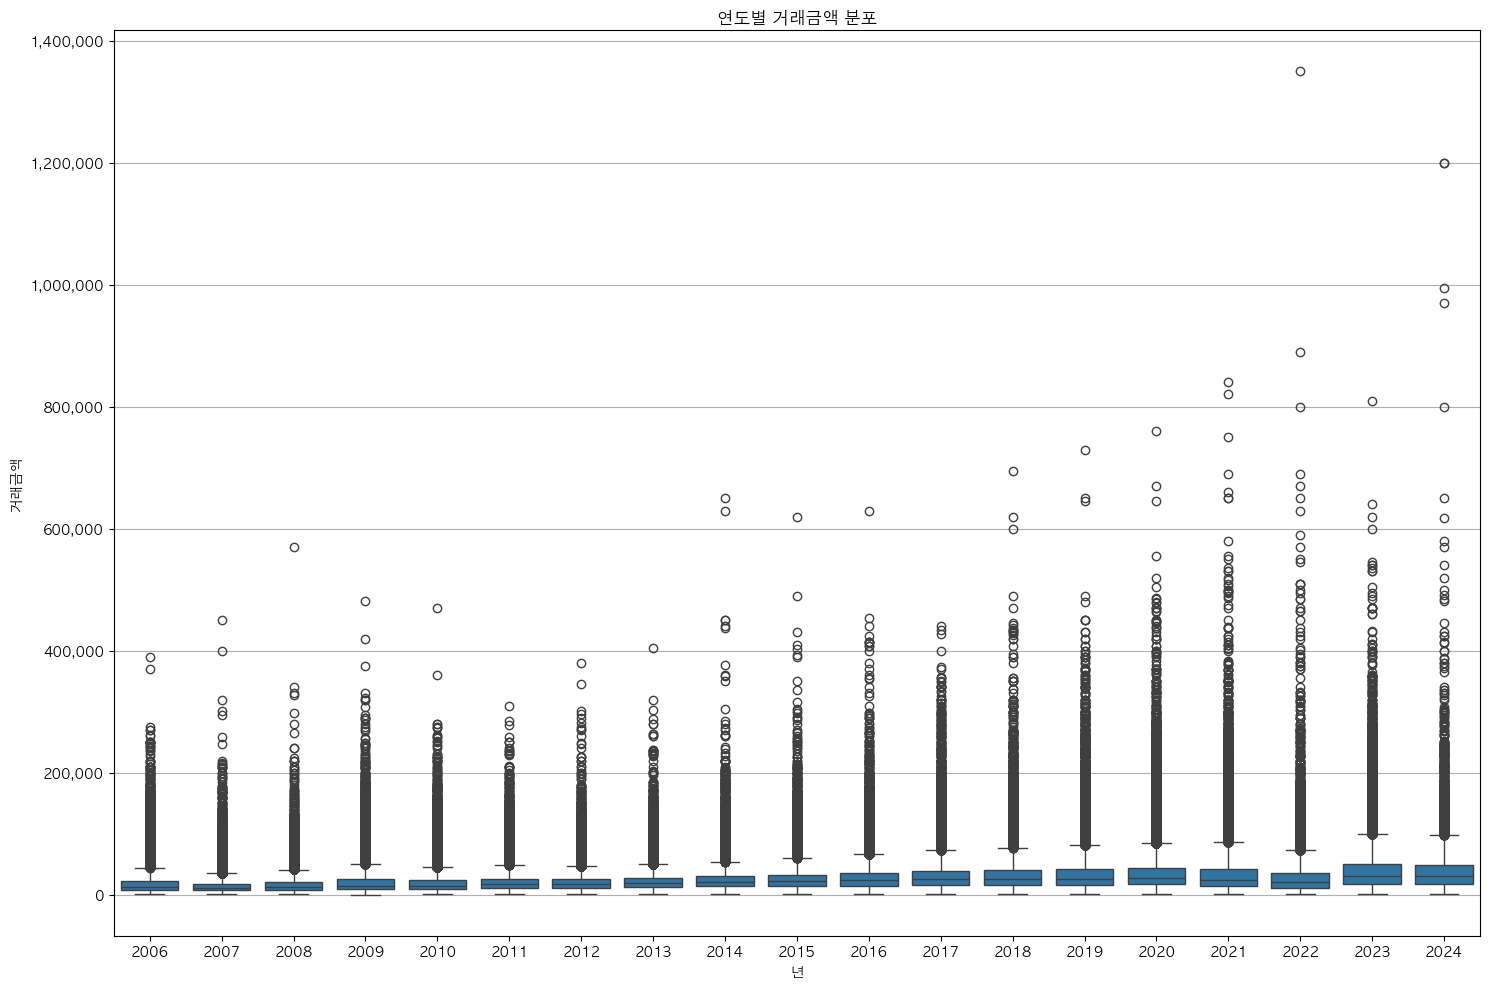

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
import matplotlib.ticker as ticker

# 지역 코드 사전 정의


  # 실제 데이터베이스 URI로 대체해야 합니다.

# apt 테이블에서 모든 데이터 가져오기
query = text('SELECT * FROM apt ORDER BY RANDOM() LIMIT 1000000')
with eng.connect() as conn:
    df = pd.read_sql(query, conn)

# '거래금액'과 '법정동시군구코드', '법정동읍면동코드' 칼럼을 숫자 형식으로 변환 (쉼표 제거 후 변환)
df['거래금액'] = df['거래금액'].replace(',', '', regex=True).astype(float)
df['법정동시군구코드'] = df['법정동시군구코드'].astype(str)
df['법정동읍면동코드'] = df['법정동읍면동코드'].astype(str)


# 상자그림 그리기
plt.figure(figsize=(15, 10))
sns.boxplot(x='년', y='거래금액', data=df, order=sorted(df['년'].unique()))
plt.xlabel('년')
plt.ylabel('거래금액')
plt.title('연도별 거래금액 분포')
plt.grid(True, axis='y')

# y축 숫자 형식을 변경하여 모든 숫자를 표시
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f'{y:,.0f}'))

plt.tight_layout()
plt.show()


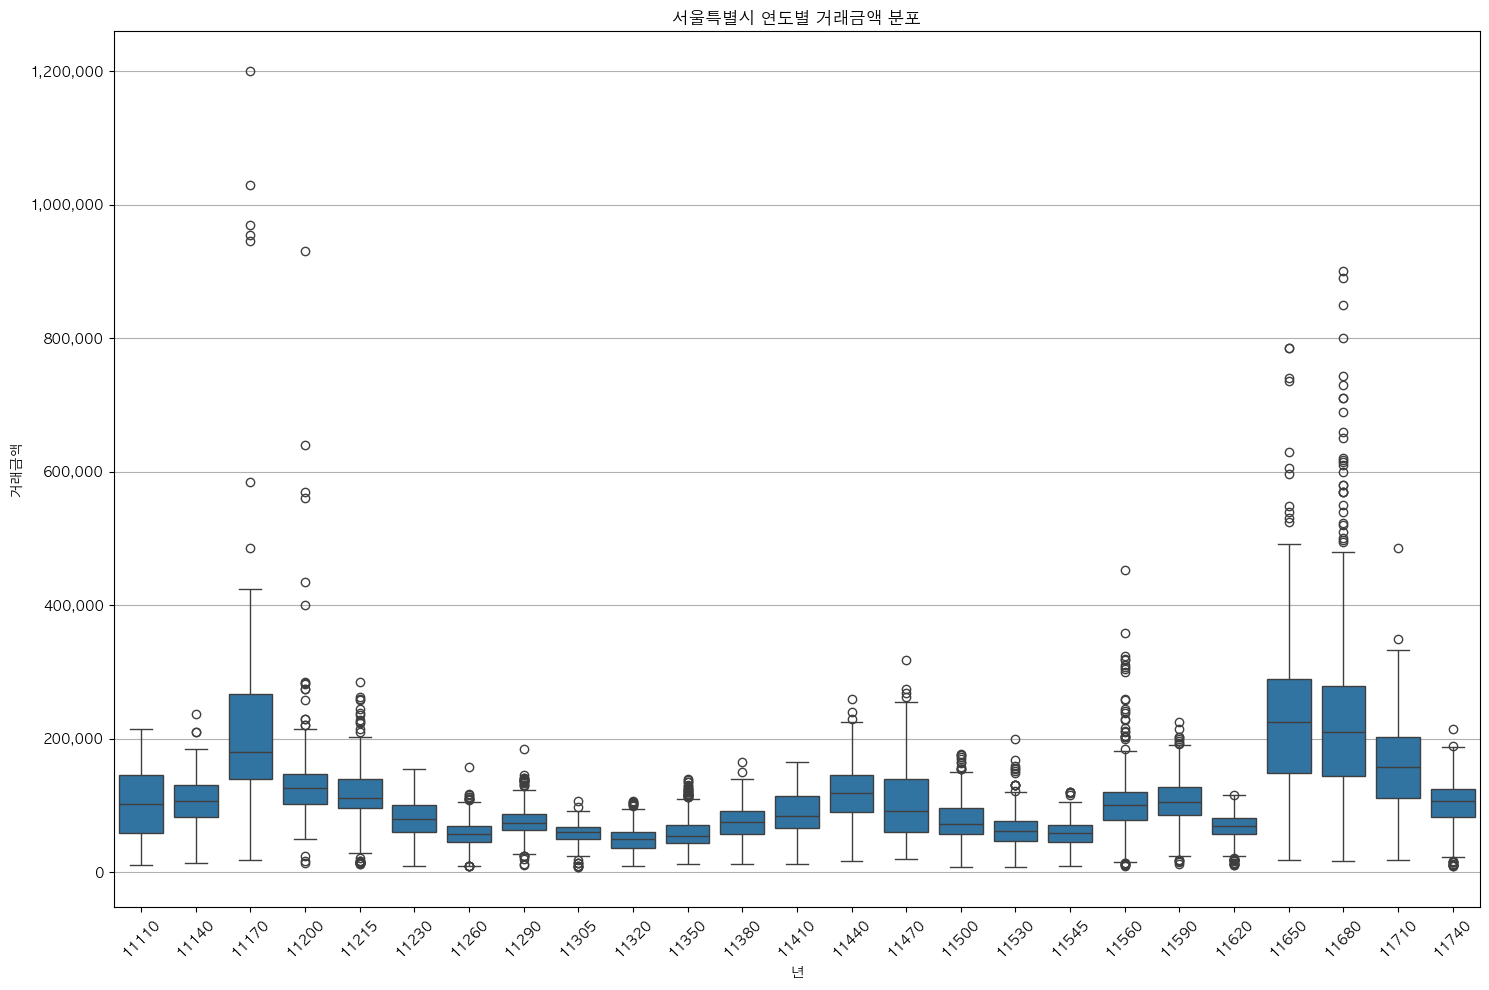

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
import matplotlib.ticker as ticker

# 데이터베이스 연결 설정


# apt 테이블에서 법정동시군구코드 앞 두 자리가 11인 데이터 중 랜덤으로 10000개 가져오기
query = text('SELECT * FROM apt WHERE substr(법정동시군구코드, 1, 2) = "11" AND "년" = 2023 ORDER BY RANDOM() LIMIT 10000')
with eng.connect() as conn:
    df = pd.read_sql(query, conn)

# '거래금액' 칼럼을 숫자 형식으로 변환 (쉼표 제거 후 변환)
df['거래금액'] = df['거래금액'].replace(',', '', regex=True).astype(float)

# 상자그림 그리기
plt.figure(figsize=(15, 10))
sns.boxplot(x='법정동시군구코드', y='거래금액', data=df, order=sorted(df['법정동시군구코드'].unique()))
plt.xlabel('지역구')
plt.ylabel('거래금액')
plt.title('서울특별시 지역구별 거래금액 분포 (2023년)')
plt.grid(True, axis='y')

# x축 레이블 45도 회전
plt.xticks(rotation=45)

# y축 숫자 형식을 변경하여 모든 숫자를 표시
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f'{y:,.0f}'))

plt.tight_layout()
plt.show()


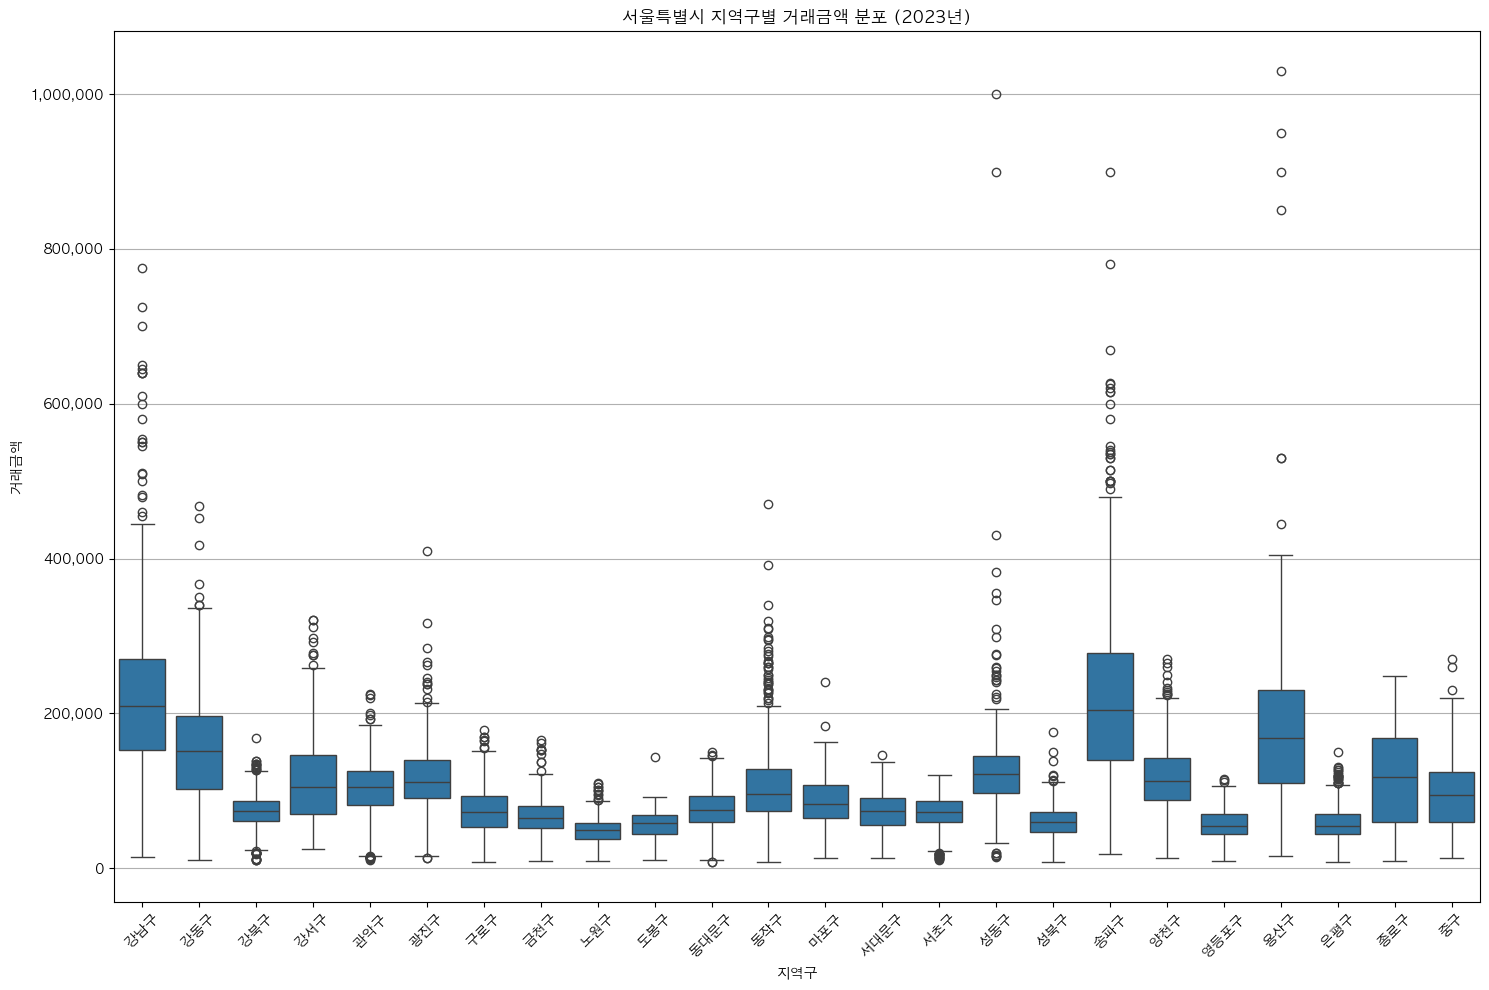

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
import matplotlib.ticker as ticker


# 서울특별시의 지역구 코드와 이름 매핑
region_code_to_name = {
    '11110': '종로구',
    '11140': '중구',
    '11170': '용산구',
    '11200': '성동구',
    '11215': '광진구',
    '11230': '동대문구',
    '11245': '중랑구',
    '11260': '성북구',
    '11290': '강북구',
    '11305': '도봉구',
    '11320': '노원구',
    '11350': '은평구',
    '11380': '서대문구',
    '11410': '마포구',
    '11440': '양천구',
    '11470': '강서구',
    '11500': '구로구',
    '11530': '금천구',
    '11545': '영등포구',
    '11560': '동작구',
    '11590': '관악구',
    '11620': '서초구',
    '11650': '강남구',
    '11680': '송파구',
    '11710': '강동구'
}

# apt 테이블에서 법정동시군구코드 앞 두 자리가 11인 데이터 중 랜덤으로 10000개 가져오기
query = text('SELECT * FROM apt WHERE substr(법정동시군구코드, 1, 2) = "11" AND "년" = 2023 ORDER BY RANDOM() LIMIT 10000')
with eng.connect() as conn:
    df = pd.read_sql(query, conn)

# '거래금액' 칼럼을 숫자 형식으로 변환 (쉼표 제거 후 변환)
df['거래금액'] = df['거래금액'].replace(',', '', regex=True).astype(float)

# 법정동시군구코드를 지역구명으로 매핑
df['지역구'] = df['법정동시군구코드'].map(region_code_to_name)
# NaN 값 제거
df = df.dropna(subset=['지역구'])
# 상자그림 그리기
plt.figure(figsize=(15, 10))
sns.boxplot(x='지역구', y='거래금액', data=df, order=sorted(df['지역구'].unique()))
plt.xlabel('지역구')
plt.ylabel('거래금액')
plt.title('서울특별시 지역구별 거래금액 분포 (2023년)')
plt.grid(True, axis='y')

# x축 레이블 45도 회전
plt.xticks(rotation=45)

# y축 숫자 형식을 변경하여 모든 숫자를 표시
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f'{y:,.0f}'))

plt.tight_layout()
plt.show()


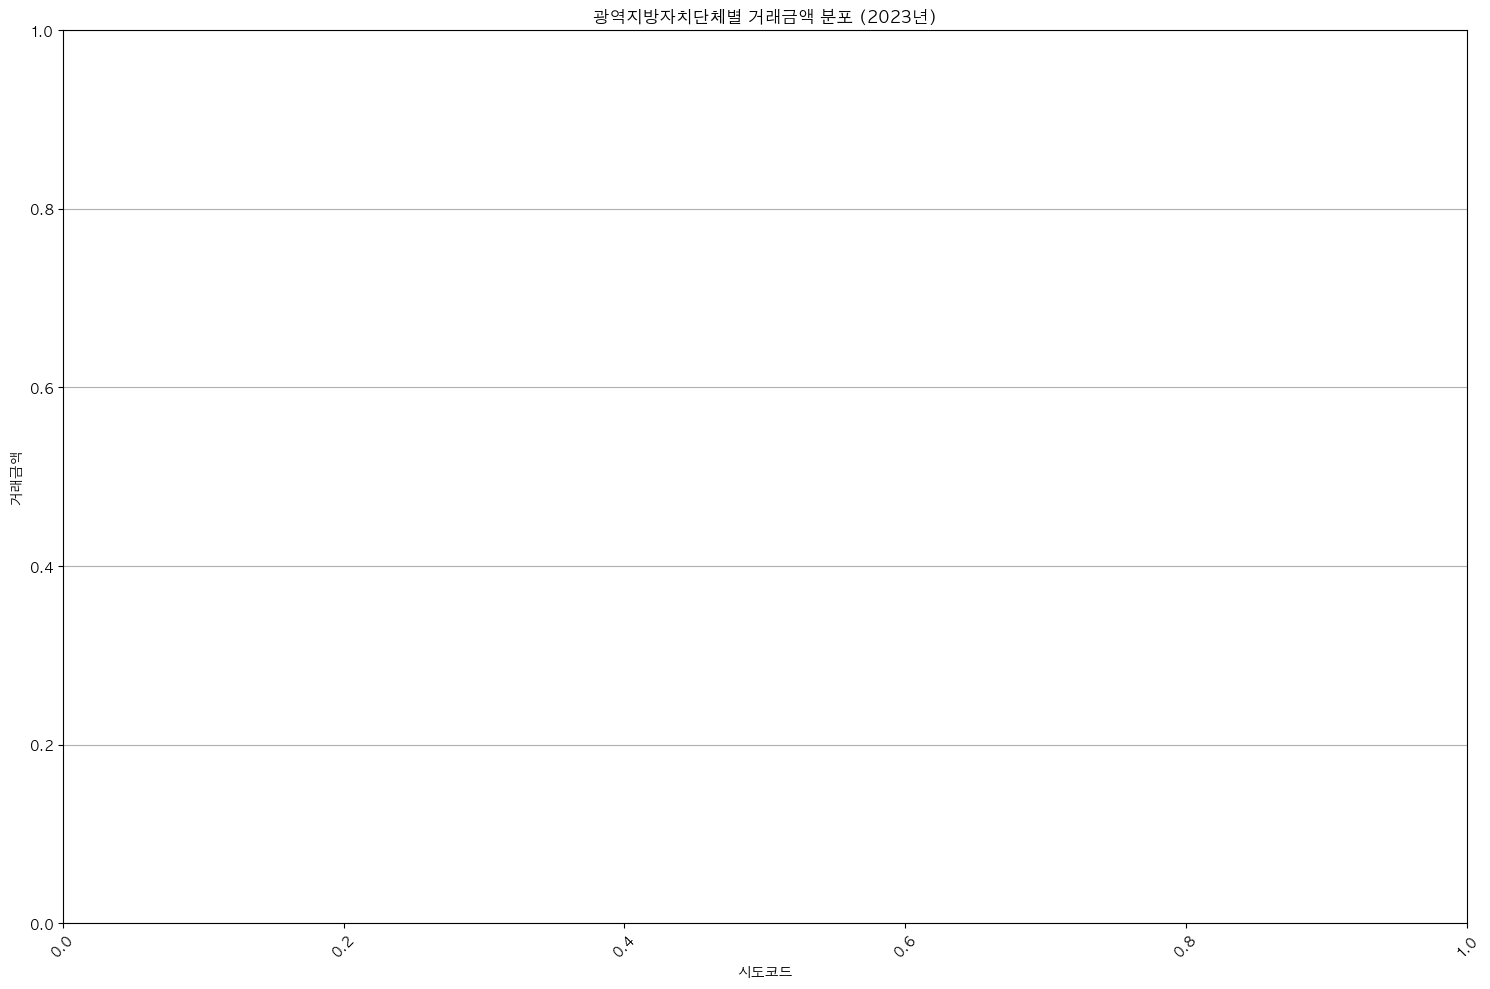

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text

region_dict = {
    '11': '서울특별시',
    '26': '부산광역시',
    '27': '대구광역시',
    '28': '인천광역시',
    '29': '광주광역시',
    '30': '대전광역시',
    '31': '울산광역시',
    '36': '세종특별자치시',
    '41': '경기도',
    '42': '강원도',
    '43': '충청북도',
    '44': '충청남도',
    '45': '전라북도',
    '46': '전라남도',
    '47': '경상북도',
    '48': '경상남도',
    '50': '제주특별자치도'
}

# apt 테이블에서 데이터 가져오기
query = text('SELECT * FROM apt WHERE substr(법정동시군구코드, 1, 2) = "11" & "년" = 2024 ')
with eng.connect() as conn:
    df = pd.read_sql(query, conn)

# '거래금액'과 '법정동시군구코드', '법정동읍면동코드' 칼럼을 숫자 형식으로 변환 (쉼표 제거 후 변환)
df['거래금액'] = df['거래금액'].replace(',', '', regex=True).astype(float)
df['법정동시군구코드'] = df['법정동시군구코드'].astype(str)
df['법정동읍면동코드'] = df['법정동읍면동코드'].astype(str)

# 법정동코드를 생성하고 첫 두 자리 추출
df['법정동코드'] = df['법정동시군구코드'] + df['법정동읍면동코드']
df['시도코드'] = df['법정동코드'].str[:2]
df['시군구명'] = df['법정동코드'].str[:5]
df['시도명'] = df['시도코드'].map(region_dict)
# 상자그림 그리기
plt.figure(figsize=(15, 10))
sns.boxplot(x='시군구명', y='거래금액', data=df, order=df['시군구명'].unique())
plt.xlabel('시도코드')
plt.ylabel('거래금액')
plt.title('광역지방자치단체별 거래금액 분포 (2023년)')
plt.grid(True, axis='y')
plt.xticks(rotation = 45)
# y축 숫자 형식을 변경하여 모든 숫자를 표시

plt.tight_layout()
plt.show()


## 연도별 법정동의 개수

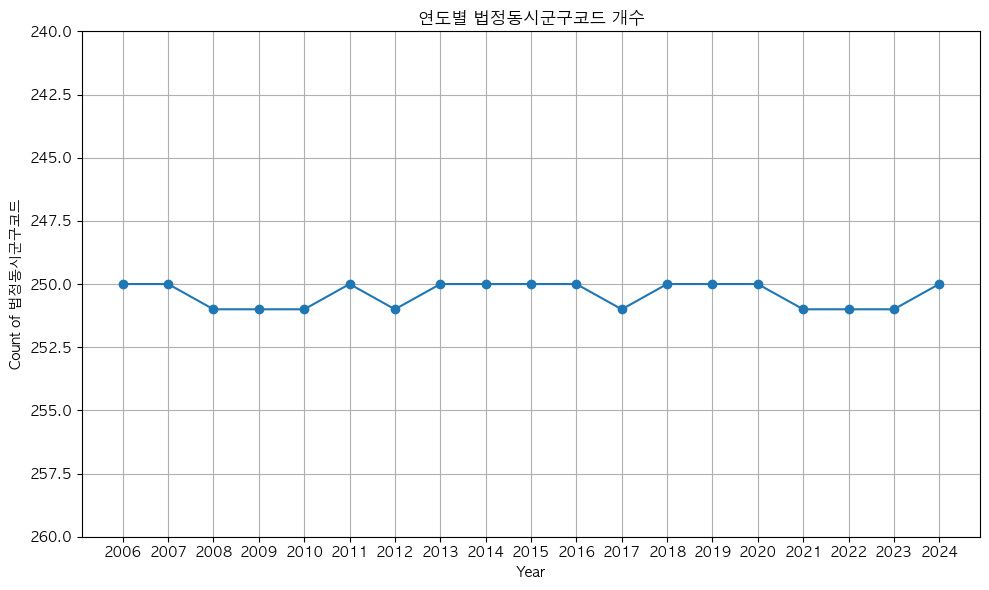

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text



# 년별 법정동시군구코드의 개수를 집계하는 쿼리
query = text('''
    SELECT 년 as year, COUNT(DISTINCT 법정동시군구코드) as count
    FROM apt
    GROUP BY 년
    ORDER BY 년
''')

# 데이터베이스 연결 및 쿼리 실행
with eng.connect() as conn:
    result = conn.execute(query)
    data = result.fetchall()

# 결과를 DataFrame으로 변환
df = pd.DataFrame(data, columns=['year', 'count'])

# 'year' 칼럼을 datetime 형식으로 변환 (연도만 포함)
df['year'] = pd.to_datetime(df['year'], format='%Y')

# 'year' 칼럼을 인덱스로 설정
df.set_index('year', inplace=True)

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['count'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Count of 법정동시군구코드')
plt.title('연도별 법정동시군구코드 개수')
plt.ylim(top = 240, bottom = 260)
plt.grid(True)

# x축 눈금 설정 (연도로 표시)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())

# x축 레이블 회전
plt.tight_layout()
plt.show()


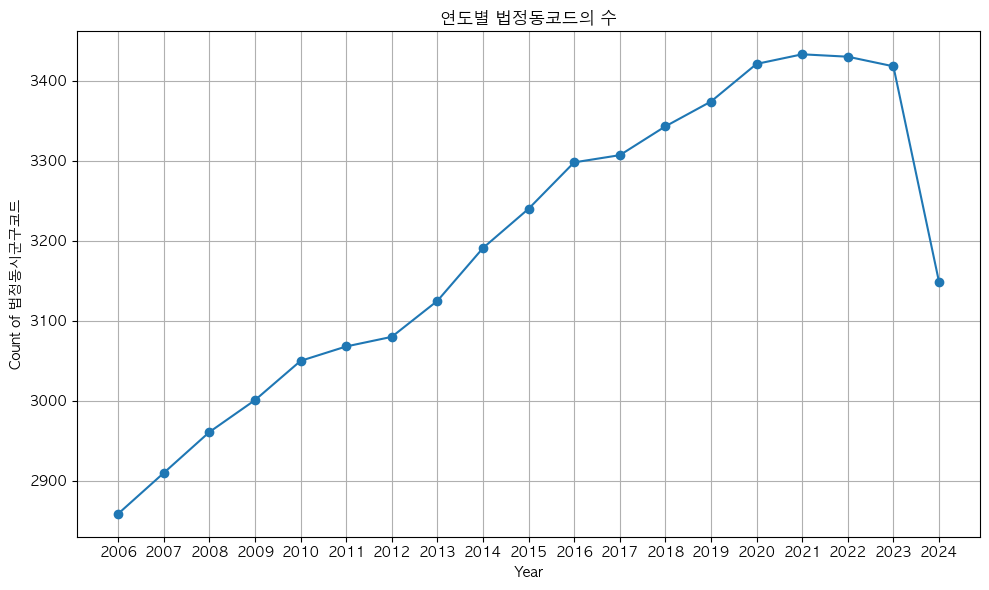

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text



# 년별 법정동시군구코드의 개수를 집계하는 쿼리
query = text('''
    SELECT sub.year, COUNT(DISTINCT sub.법정동코드) as count
    FROM (
             SELECT 년 as year, 법정동시군구코드 || 법정동읍면동코드 AS 법정동코드
             FROM apt
    ) sub
    GROUP BY sub.year
    ORDER BY sub.year
''')

# 데이터베이스 연결 및 쿼리 실행
with eng.connect() as conn:
    result = conn.execute(query)
    data = result.fetchall()

# 결과를 DataFrame으로 변환
df = pd.DataFrame(data, columns=['year', 'count'])

# 'year' 칼럼을 datetime 형식으로 변환 (연도만 포함)
df['year'] = pd.to_datetime(df['year'], format='%Y')

# 'year' 칼럼을 인덱스로 설정
df.set_index('year', inplace=True)

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['count'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('코드의 . ')
plt.title('연도별 법정동코드(읍면동)의 수')
plt.grid(True)

# x축 눈금 설정 (연도로 표시)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())

# x축 레이블 회전
plt.tight_layout()
plt.show()


        지역명      지니계수
14     충청북도  0.375940
13     충청남도  0.371425
11     전라남도  0.356336
2      경상북도  0.356085
6     부산광역시  0.351529
7     서울특별시  0.337292
1      경상남도  0.330343
3     광주광역시  0.327480
9     울산광역시  0.325162
5     대전광역시  0.318132
4     대구광역시  0.306537
12  제주특별자치도  0.306023
0       경기도  0.303188
10    인천광역시  0.284789
8   세종특별자치시  0.256857


/var/folders/_7/gw7m14q925731rjlj61v1dqm0000gn/T/ipykernel_95951/2663115216.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='지역명', y='지니계수', data=gini_coefficients, palette='viridis')


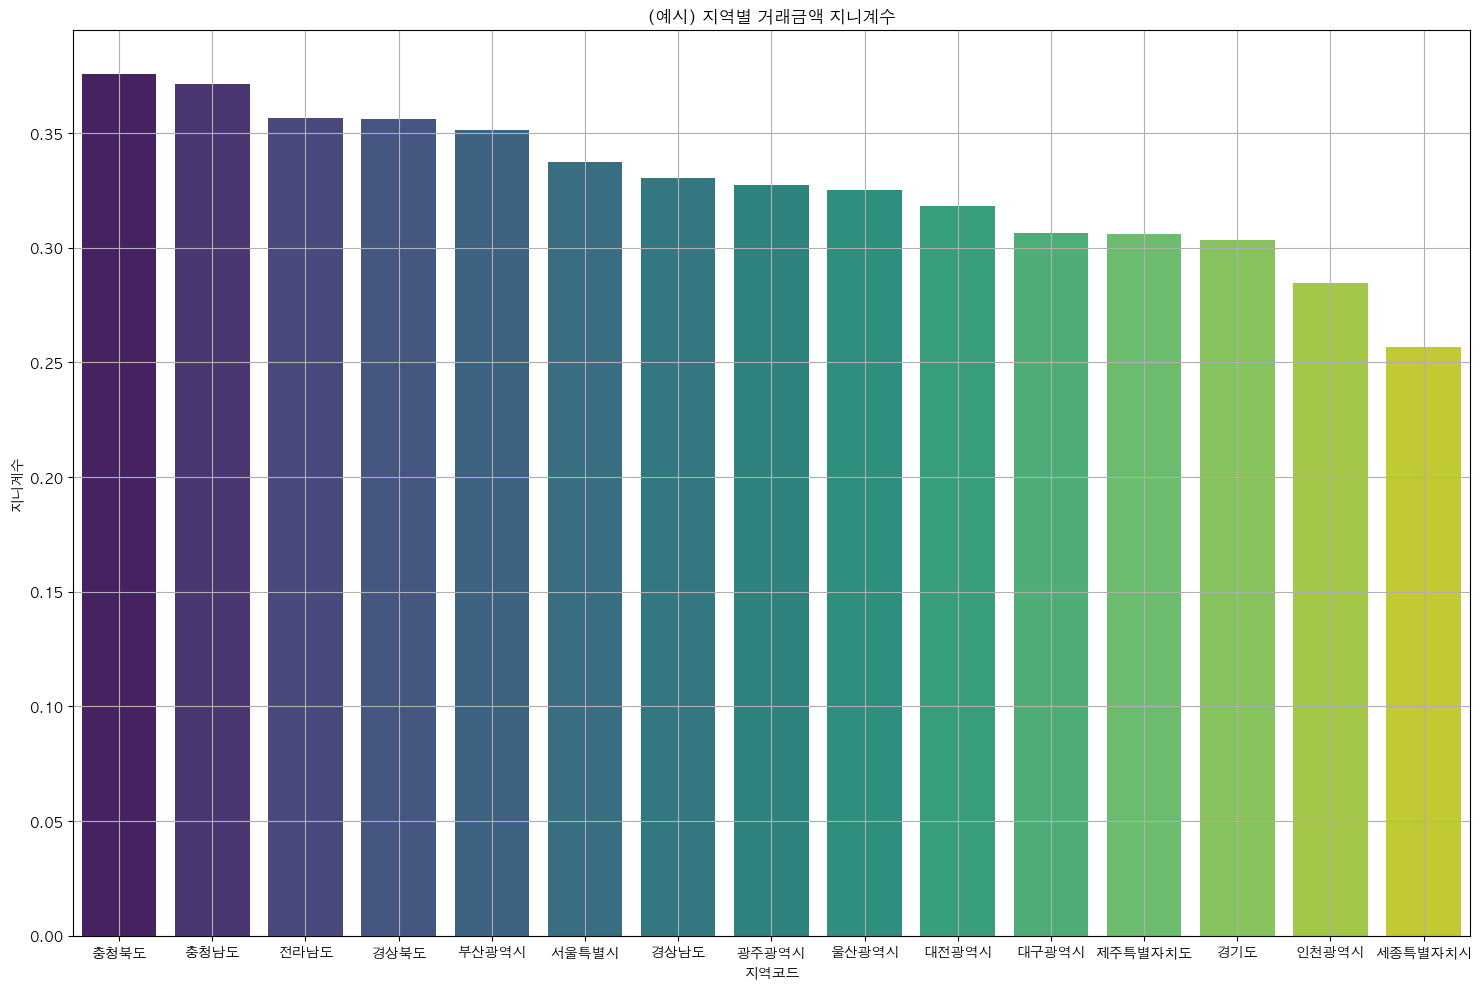

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
import numpy as np

# 지니계수 계산 함수
def gini(array):
    array = np.sort(array)  # 값 정렬
    n = len(array)
    index = np.arange(1, n + 1)
    return (2 * np.sum(index * array) - (n + 1) * np.sum(array)) / (n * np.sum(array))

region_dict = {
    '11': '서울특별시',
    '26': '부산광역시',
    '27': '대구광역시',
    '28': '인천광역시',
    '29': '광주광역시',
    '30': '대전광역시',
    '31': '울산광역시',
    '36': '세종특별자치시',
    '41': '경기도',
    '42': '강원도',
    '43': '충청북도',
    '44': '충청남도',
    '45': '전라북도',
    '46': '전라남도',
    '47': '경상북도',
    '48': '경상남도',
    '50': '제주특별자치도'
}


# '거래금액' 칼럼을 숫자 형식으로 변환 (쉼표 제거 후 변환)
df['거래금액'] = df['거래금액'].replace(',', '', regex=True).astype(float)

# 지역코드 생성 (법정동코드 앞 2자리 추출)
df['지역코드'] = df['법정동시군구코드'].str[:2]
df['지역명'] = df['지역코드'].map(region_dict)

# 지역별 지니계수 계산
gini_coefficients = df.groupby('지역명')['거래금액'].apply(gini).reset_index()
gini_coefficients.columns = ['지역명', '지니계수']
gini_coefficients = gini_coefficients.sort_values(by = '지니계수', ascending= False)

# 결과 출력
print(gini_coefficients)

# 그래프 그리기
plt.figure(figsize=(15, 10))
sns.barplot(x='지역명', y='지니계수', data=gini_coefficients, palette='viridis')
plt.xlabel('지역코드')
plt.ylabel('지니계수')
plt.title('(예시) 지역별 거래금액 지니계수 (2023년)')
plt.grid(True)
plt.tight_layout()
plt.show()
